# Курсовой проект

### Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## Построение модели классификации

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import pickle
import random

from scipy.stats import chi2_contingency
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import ttest_ind, mannwhitneyu

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC

from statsmodels.stats.weightstats import zconfint

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from catboost import Pool, cv

import warnings
warnings.simplefilter('ignore')

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):  
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 5))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (8, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
title_dict = {'fontsize': 20, 'fontweight': 'bold', 'family': 'Calibri'}
label_dict = {'fontsize': '14', 'family': 'Calibri'}

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Пути к директориям и файлам**

In [8]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

In [9]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.head()

Id Home Ownership  Annual Income Years in current job  Tax Liens  \
0   0       Own Home       482087.0                  NaN        0.0   
1   1       Own Home      1025487.0            10+ years        0.0   
2   2  Home Mortgage       751412.0              8 years        0.0   
3   3       Own Home       805068.0              6 years        0.0   
4   4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [10]:
train.shape

(7500, 18)

In [11]:
train.iloc[0]

Id                                               0
Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

In [13]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

Id Home Ownership  Annual Income Years in current job  Tax Liens  \
0  7500           Rent            NaN              4 years        0.0   
1  7501           Rent       231838.0               1 year        0.0   
2  7502  Home Mortgage      1152540.0              3 years        0.0   
3  7503  Home Mortgage      1220313.0            10+ years        0.0   
4  7504  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

In [14]:
test.shape

(2500, 17)

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
Id                              2500 non-null int64
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    198

In [16]:
test.describe()

Id  Annual Income    Tax Liens  Number of Open Accounts  \
count  2500.00000   1.987000e+03  2500.000000              2500.000000   
mean   8749.50000   1.366922e+06     0.035200                11.184400   
std     721.83216   9.171252e+05     0.386291                 4.852774   
min    7500.00000   1.065330e+05     0.000000                 1.000000   
25%    8124.75000   8.523115e+05     0.000000                 8.000000   
50%    8749.50000   1.178475e+06     0.000000                10.000000   
75%    9374.25000   1.629734e+06     0.000000                14.000000   
max    9999.00000   1.497561e+07    15.000000                48.000000   

       Years of Credit History  Maximum Open Credit  \
count              2500.000000         2.500000e+03   
mean                 18.325920         7.105704e+05   
std                   7.254659         1.511983e+06   
min                   3.900000         0.000000e+00   
25%                  13.400000         2.785860e+05   
50%                  17.000000         4.786760e+05   
75%                  22.100000         8.025985e+05   
max                  53.400000         5.448439e+07   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2500.000000                   1142.000000   2497.000000   
mean                    0.162000                     34.181261      0.106928   
std                     0.559894                     22.024277      0.357189   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     30.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                    15.000000                     82.000000      5.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  
count         2.500000e+03            2.500000e+03   2500.000000   1987.000000  
mean          1.215572e+07            2.963966e+05  18271.340000   1234.516860  
std           3.226097e+07            3.783020e+05  11543.881469   1740.219442  
min           1.542200e+04            0.000000e+00     93.000000    585.000000  
25%           1.871265e+05            1.101145e+05  10024.750000    710.000000  
50%           3.223660e+05            2.073850e+05  16642.500000    731.000000  
75%           5.225825e+05            3.663485e+05  24146.000000    743.000000  
max           1.000000e+08            6.030087e+06  93555.000000   7480.000000

### Обработка пропусков

In [17]:
len(train) - train.count()

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [18]:
len(test) - test.count()

Id                                 0
Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

**Пропуски в количественных данных**

Пропуски в столбце "Months since last delinquent" - количество месяцев с последней просрочки платежа, заполним нулями.

In [19]:
train['Months since last delinquent'].fillna(0, inplace=True)

In [20]:
test['Months since last delinquent'].fillna(0, inplace=True)

In [21]:
# Большое количество пропусков в столбцах 'Annual Income' и 'Credit Score', сначала посмотрим на данные.

train.loc[train['Annual Income'].isnull(), :].head()

Id Home Ownership  Annual Income Years in current job  Tax Liens  \
5    5           Rent            NaN              7 years        0.0   
8    8  Home Mortgage            NaN              5 years        0.0   
9    9  Home Mortgage            NaN               1 year        0.0   
10  10  Home Mortgage            NaN             < 1 year        0.0   
16  16           Rent            NaN              7 years        0.0   

    Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
5                      12.0                     14.6             366784.0   
8                      17.0                     15.7                  0.0   
9                      10.0                     24.6             511302.0   
10                      7.0                     11.5             256322.0   
16                      6.0                     17.8             899492.0   

    Number of Credit Problems  Months since last delinquent  Bankruptcies  \
5                         0.0                           0.0           0.0   
8                         1.0                           0.0           1.0   
9                         0.0                           6.0           0.0   
10                        0.0                           0.0           0.0   
16                        0.0                           0.0           0.0   

               Purpose        Term  Current Loan Amount  \
5                other   Long Term             337304.0   
8    home improvements  Short Term             129734.0   
9   debt consolidation   Long Term             572880.0   
10  debt consolidation  Short Term             220858.0   
16  debt consolidation   Long Term             313038.0   

    Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
5                 165680.0       18692.0           NaN               1  
8                     19.0          17.0           NaN               0  
9                 205333.0       17613.0           NaN               1  
10                187492.0       14592.0           NaN               0  
16                538346.0       18844.0           NaN               1

In [22]:
train.loc[train['Annual Income'].isnull(), :].describe()

Id  Annual Income    Tax Liens  Number of Open Accounts  \
count  1557.000000            0.0  1557.000000              1557.000000   
mean   3690.201028            NaN     0.033398                11.151574   
std    2177.866805            NaN     0.280313                 4.935590   
min       5.000000            NaN     0.000000                 2.000000   
25%    1742.000000            NaN     0.000000                 8.000000   
50%    3747.000000            NaN     0.000000                10.000000   
75%    5583.000000            NaN     0.000000                14.000000   
max    7499.000000            NaN     4.000000                33.000000   

       Years of Credit History  Maximum Open Credit  \
count              1557.000000         1.557000e+03   
mean                 18.336737         1.489092e+06   
std                   7.038592         3.305621e+07   
min                   4.300000         0.000000e+00   
25%                  13.500000         2.832280e+05   
50%                  17.300000         4.862660e+05   
75%                  21.900000         7.942660e+05   
max                  51.900000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                1557.000000                   1557.000000   1555.000000   
mean                    0.171484                     15.170841      0.113826   
std                     0.500137                     22.400430      0.327673   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                      0.000000      0.000000   
50%                     0.000000                      0.000000      0.000000   
75%                     0.000000                     28.000000      0.000000   
max                     5.000000                     83.000000      2.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  \
count          1557.000000            1.557000e+03   1557.000000   
mean         300744.253051            2.860604e+05  18451.107900   
std          179179.260062            3.048984e+05  12084.036473   
min           21472.000000            0.000000e+00      0.000000   
25%          167684.000000            1.140760e+05  10071.000000   
50%          262856.000000            2.058650e+05  16048.000000   
75%          404096.000000            3.572190e+05  23883.000000   
max          788942.000000            3.944514e+06  96177.000000   

       Credit Score  Credit Default  
count           0.0     1557.000000  
mean            NaN        0.339756  
std             NaN        0.473778  
min             NaN        0.000000  
25%             NaN        0.000000  
50%             NaN        0.000000  
75%             NaN        1.000000  
max             NaN        1.000000

Text(0.5, 1.0, 'Correlation matrix')

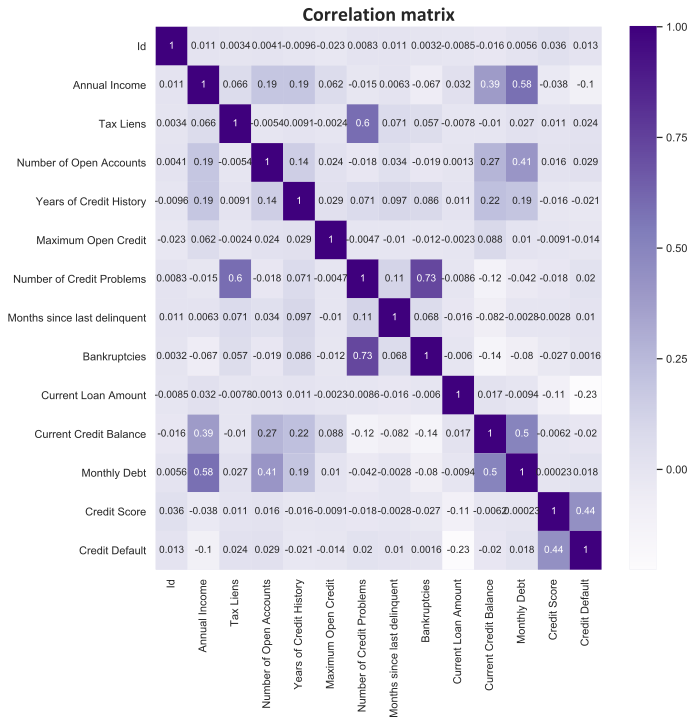

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), cmap='Purples', annot=True)
plt.title('Correlation matrix', fontdict=title_dict)

Кажется, для расчета 'Credit Score'используется признак 'Annual Income', поэтому пропуски в одних и теж же строках. Но корреляции этих признаков нет, и в строках с пропусками другие признаки ведут себя, как и во всей выборке.

Заменим пропуски количественных данных медианными значениями.

In [24]:
def fill_col(col):
    train[col].fillna(train[col].median(), inplace=True)

    
В тесте заменим пропуски на медианные значения из трейна.

In [25]:
def fill_col_test(col):    
    test[col].fillna(train[col].median(), inplace=True)

In [26]:
fill_col('Annual Income')
fill_col('Bankruptcies')
fill_col('Credit Score')

In [27]:
fill_col_test('Annual Income')
fill_col_test('Bankruptcies')
fill_col_test('Credit Score')

Заменим пропуски номинативных данных модой.

In [28]:
def fill_nom_col(col):    
    train[col].fillna(train[col].mode().iloc[0], inplace=True)

    
В тесте заменим пропуски на моду из трейна.

In [29]:
def fill_nom_col_test(col):    
    test[col].fillna(train[col].mode().iloc[0], inplace=True)

In [30]:
fill_nom_col('Years in current job')

In [31]:
fill_nom_col_test('Years in current job')

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null float64
Years in current job            7500 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    750

In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
Id                              2500 non-null int64
Home Ownership                  2500 non-null object
Annual Income                   2500 non-null float64
Years in current job            2500 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    2500 non-null float64
Bankruptcies                    2500 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    250

### Обзор данных

**Обзор целевой переменной**

In [34]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [35]:
target = 'Credit Default'

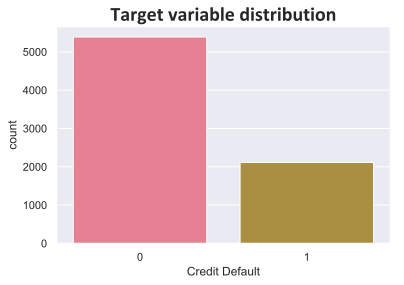

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=train)
plt.title('Target variable distribution', fontdict=title_dict);

Выборка не сбалансированная по целевой переменной.

**Обзор количественных признаков, приведение типов и замена выбросов на медианные значения**

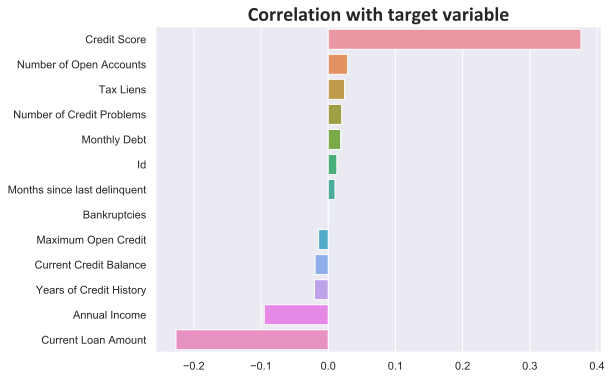

In [37]:
corr_with_target = train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable', fontdict=title_dict);

Самая большая корреляция с целевой переменной у признака 'Credit Score', на втором месте, но со знаком минус признак 'Current Loan Amount' - текущая сумма кредита.

In [38]:
train.describe()

Id  Annual Income    Tax Liens  Number of Open Accounts  \
count  7500.000000   7.500000e+03  7500.000000              7500.000000   
mean   3749.500000   1.325286e+06     0.030133                11.130933   
std    2165.207842   7.567551e+05     0.271604                 4.908924   
min       0.000000   1.645970e+05     0.000000                 2.000000   
25%    1874.750000   9.311330e+05     0.000000                 8.000000   
50%    3749.500000   1.168386e+06     0.000000                10.000000   
75%    5624.250000   1.499974e+06     0.000000                14.000000   
max    7499.000000   1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   7500.000000   7500.000000   
mean                    0.170000                     15.815200      0.116933   
std                     0.498598                     22.649441      0.346904   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                      0.000000      0.000000   
50%                     0.000000                      0.000000      0.000000   
75%                     0.000000                     29.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   7500.000000     7500.000000  
mean    1063.877333        0.281733  
std     1438.335832        0.449874  
min      585.000000        0.000000  
25%      718.000000        0.000000  
50%      731.000000        0.000000  
75%      740.000000        1.000000  
max     7510.000000        1.000000

In [39]:
def feat_plot(col):        
    fig, ax = plt.subplots(nrows=2, ncols=2)
    ax1, ax2, ax3, ax4 = ax.flatten()
    
    default = train.loc[train ['Credit Default'] == 1, col]
    not_default = train.loc[train ['Credit Default'] == 0, col]
    ax1.hist((default, not_default), bins=20, histtype='stepfilled', alpha=0.3, color=('red', 'green'),
             density=True, label=('Credit Default 1', 'Credit Default 0'))
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_title('Credit Default distribution')
     
    ax2.boxplot(train[col])
    ax2.set_title('Boxplot')
    
   # Сравним с тестовым датасетом.

    ax3.hist(test[col], bins=20)
    ax3.set_title('Test_feature Distribution')
    
    ax4.boxplot(test[col])
    ax4.set_title('Test_feature Boxplot')
    
    fig.set_size_inches(10, 8)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)    

In [40]:
def change_col(col):
    '''
    Заменяет выбросы медианными значениями.
    '''
    train.loc[train[col] > train[col].quantile(.98), col] = train[col].median()
    train.loc[train[col] < train[col].quantile(.02), col] = train[col].median()

In [41]:
def change_col_test(col):
    '''
    Заменяет значения, большие n, медианными значениями из трейна.
    '''
    test.loc[test[col] > test[col].quantile(.98), col] = train[col].median()
    test.loc[test[col] < test[col].quantile(.02), col] = train[col].median()

**Annual Income - годовой доход**

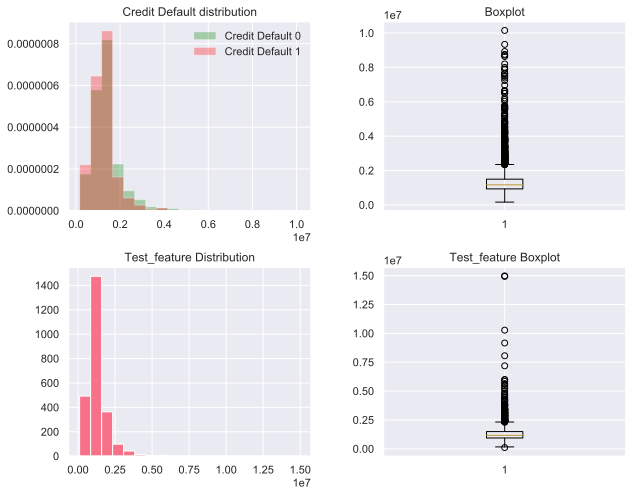

In [42]:
feat_plot('Annual Income')

Мы видим, что данные содержат выбросы. Заменим нетипичные значения медианными.

In [43]:
change_col('Annual Income')

Сразу проделаем ту же операцию с тестовой выборкой.

In [44]:
change_col_test('Annual Income')

Еще раз взглянем на наш признак.

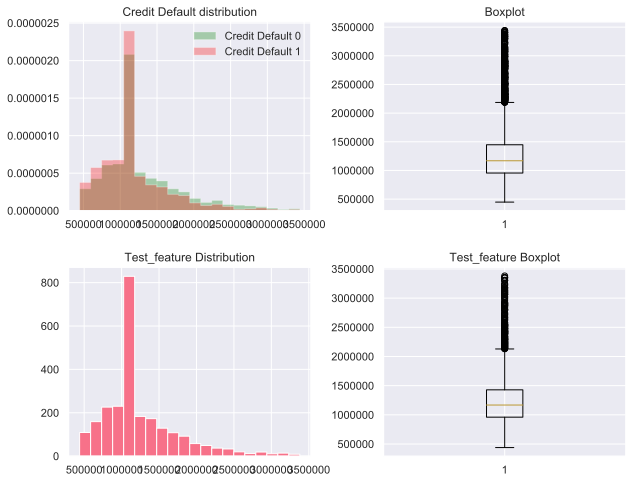

In [45]:
feat_plot('Annual Income')

**Tax Liens - налоговые льготы**

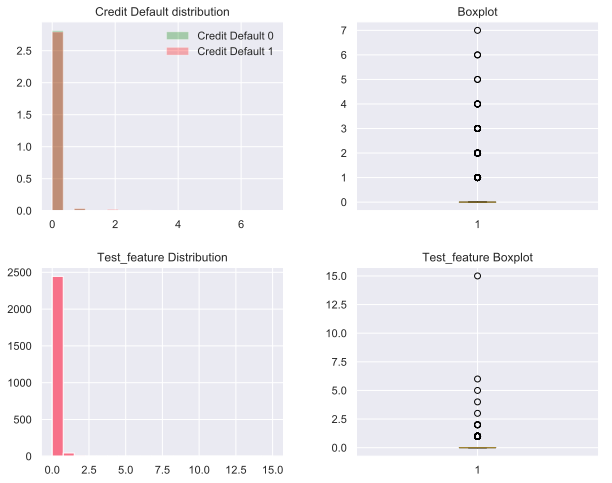

In [46]:
feat_plot('Tax Liens')

Налоговые льготы - очевидно, категориальный признак.

In [47]:
train['Tax Liens'].unique()

array([0., 3., 1., 2., 4., 6., 5., 7.])

In [48]:
train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Приведем признак 'Налоговые льготы' к биномиальному типу. Те, у кого льготы есть, получат класс 1, у кого нет - 0.

In [49]:
train.loc[train['Tax Liens'] > 0, 'Tax Liens'] = 1
train['Tax Liens'] = train['Tax Liens'].astype('int')

Сразу внесем изменения в тест.

In [50]:
test.loc[test['Tax Liens'] > 0, 'Tax Liens'] = 1
test['Tax Liens'] = test['Tax Liens'].astype('int')

**Number of Open Accounts - количество открытых счетов**

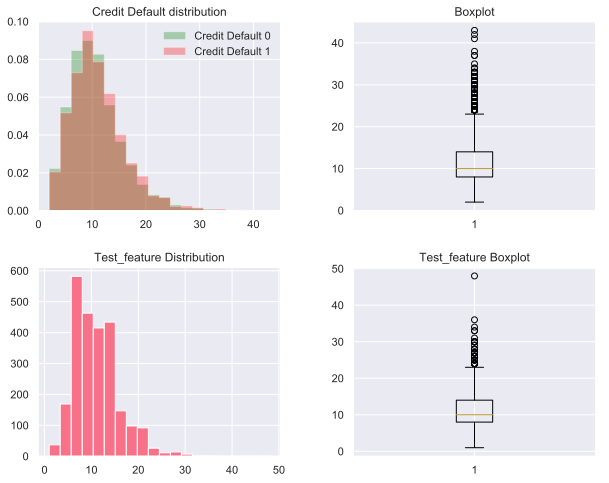

In [51]:
feat_plot('Number of Open Accounts')

'Количество открытых счетов' содержит выбросы. Изменим выбросы на медианные значения.

In [52]:
change_col('Number of Open Accounts')

Сразу проделаем ту же операцию с тестовой выборкой.

In [53]:
change_col_test('Number of Open Accounts')

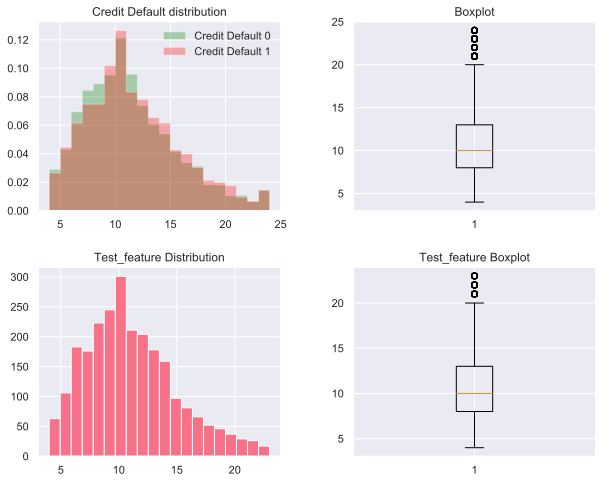

In [54]:
feat_plot('Number of Open Accounts')

**Years of Credit History - количество лет кредитной истории**

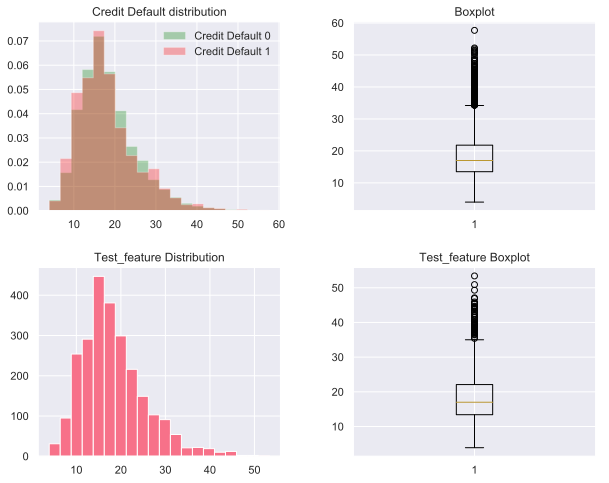

In [55]:
feat_plot('Years of Credit History')

In [56]:
change_col('Years of Credit History')

In [57]:
change_col_test('Years of Credit History')

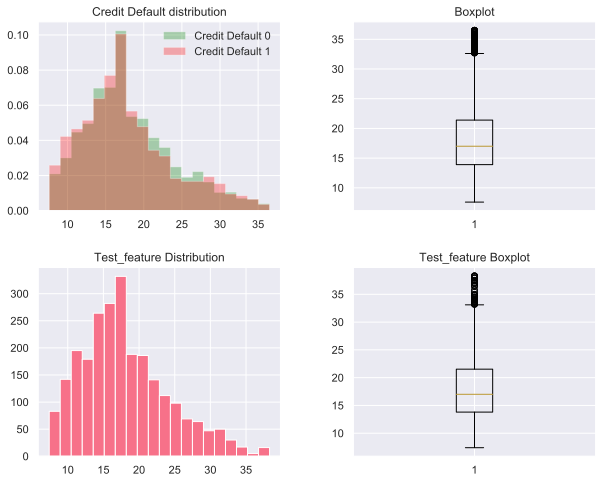

In [58]:
feat_plot('Years of Credit History')

**Maximum Open Credit - наибольший открытый кредит**

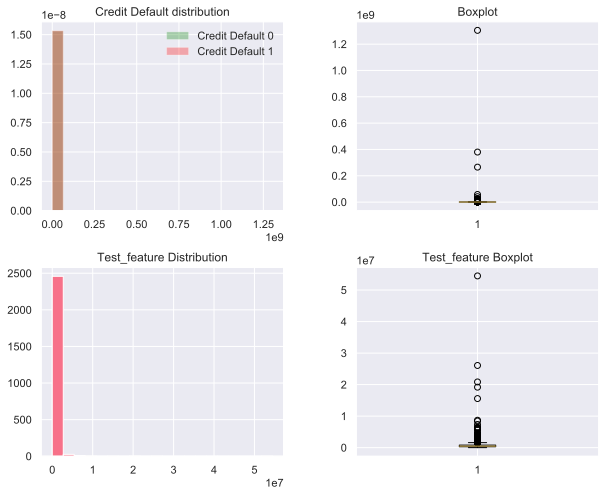

In [59]:
feat_plot('Maximum Open Credit')

Поле 'наибольший открытый кредит' явно содержит выбросы. Заменим выбросы медианами.

In [60]:
change_col('Maximum Open Credit')

Сразу проделаем ту же операцию с тестовой выборкой.

In [61]:
change_col_test('Maximum Open Credit')

Еще раз взглянем на наш признак.

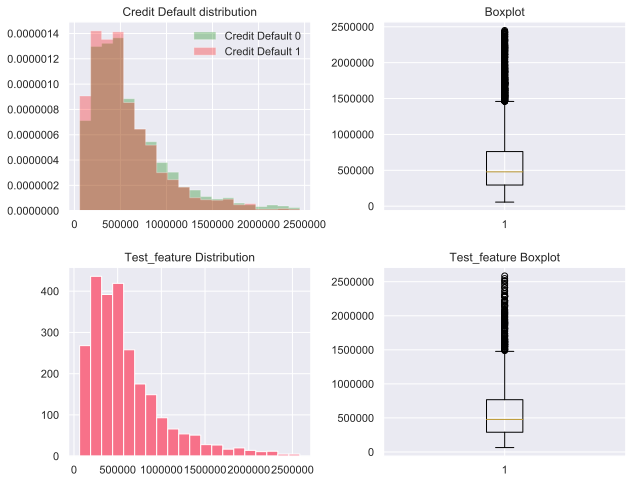

In [62]:
feat_plot('Maximum Open Credit')

**Number of Credit Problems - количество проблем с кредитом**

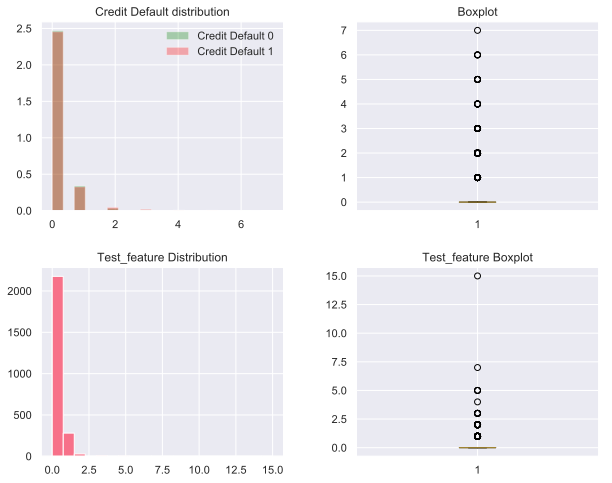

In [63]:
feat_plot('Number of Credit Problems')

'Количество проблем с кредитом' - это категориальный признак.

In [64]:
train['Number of Credit Problems'].unique()

array([1., 0., 3., 2., 6., 4., 5., 7.])

Присвоим сласс 0 тем, кто не имел проблем с кредитом, и 1 - тем, кто имел.

In [65]:
train.loc[train['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
train['Number of Credit Problems'] = train['Number of Credit Problems'].astype('int')

Повторим операцию для теста.

In [66]:
test.loc[test['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
test['Number of Credit Problems'] = test['Number of Credit Problems'].astype('int')

**Months since last delinquent - количество месяцев с последней просрочки платежа**

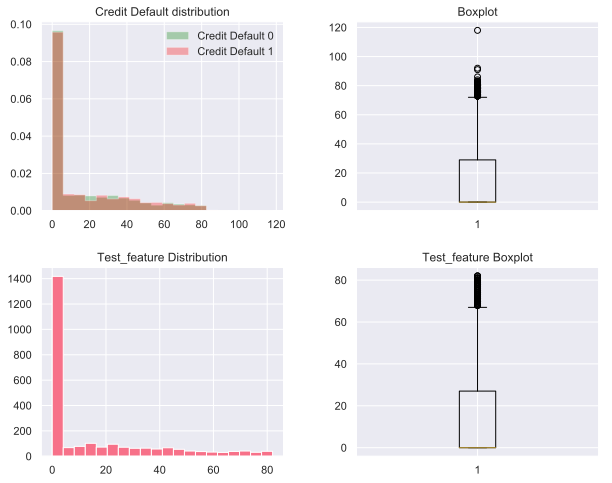

In [67]:
feat_plot('Months since last delinquent')

Этот признак имеет смысл привести к биномиальному. 1 - просрочка была, 0 - не было.

In [68]:
train.loc[train['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
train['Months since last delinquent'] = train['Months since last delinquent'].astype('int')

In [69]:
test.loc[test['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
test['Months since last delinquent'] = test['Months since last delinquent'].astype('int')

**Bankruptcies - банкротства**

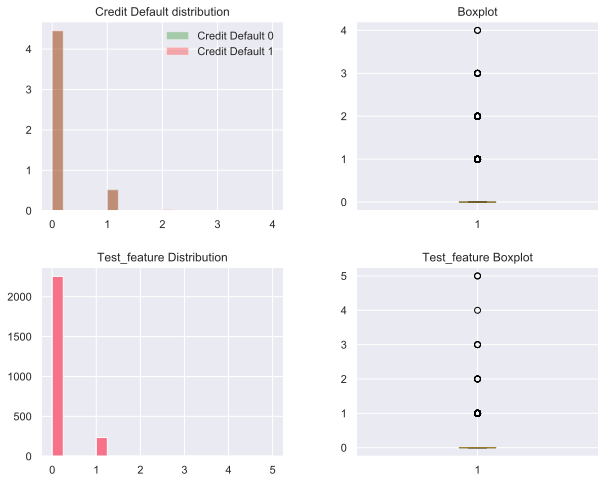

In [70]:
feat_plot('Bankruptcies')

Опять категориальный признак.

In [71]:
train['Bankruptcies'].unique()

array([1., 0., 3., 2., 4.])

Не имевшим банкротсв присвоим класс 0, а всем остальным - 1.

In [72]:
train.loc[train['Bankruptcies'] > 0, 'Bankruptcies'] = 1
train['Bankruptcies'] = train['Bankruptcies'].astype('int')

In [73]:
test.loc[test['Bankruptcies'] > 0, 'Bankruptcies'] = 1
test['Bankruptcies'] = test['Bankruptcies'].astype('int')

**Current Loan Amount - текущая сумма кредита**

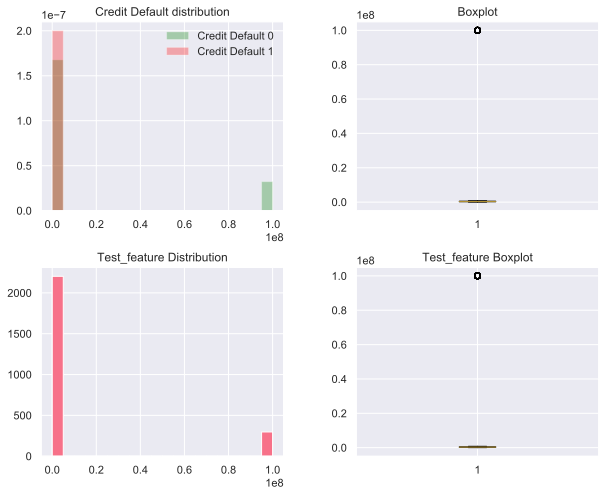

In [74]:
feat_plot('Current Loan Amount')

In [75]:
change_col('Current Loan Amount')

In [76]:
change_col_test('Current Loan Amount')

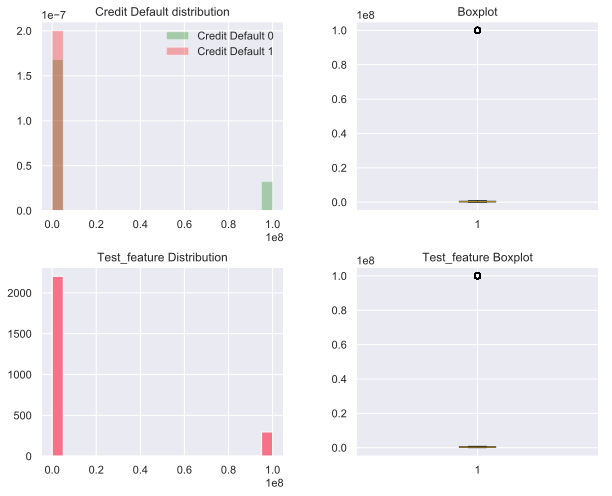

In [77]:
feat_plot('Current Loan Amount')

**Current Credit Balance - текущий кредитный баланс**

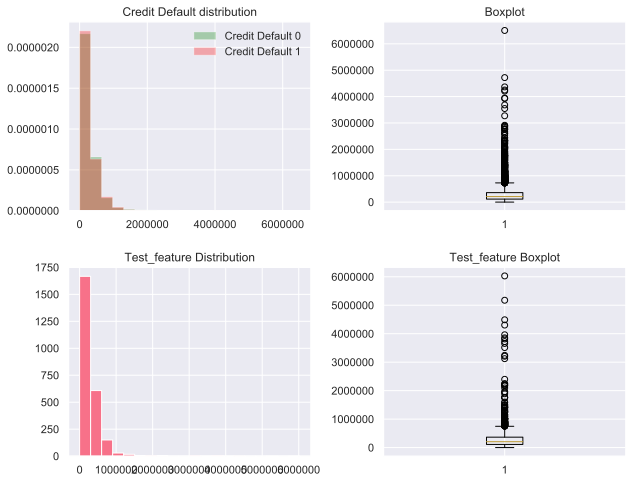

In [78]:
feat_plot('Current Credit Balance')

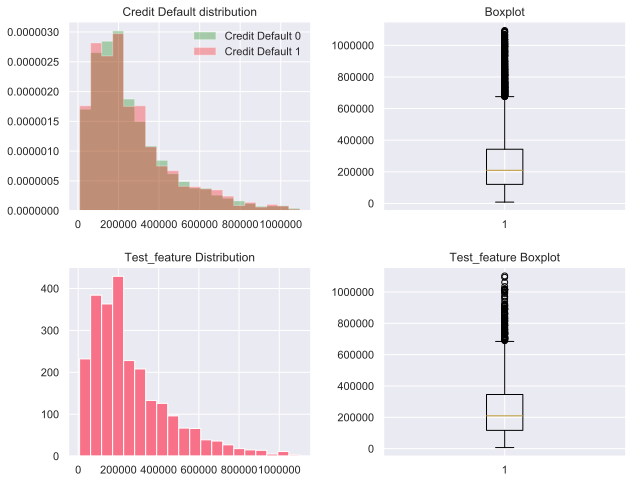

In [79]:
change_col('Current Credit Balance')
change_col_test('Current Credit Balance')
feat_plot('Current Credit Balance')

**Monthly Debt - ежемесячный долг**

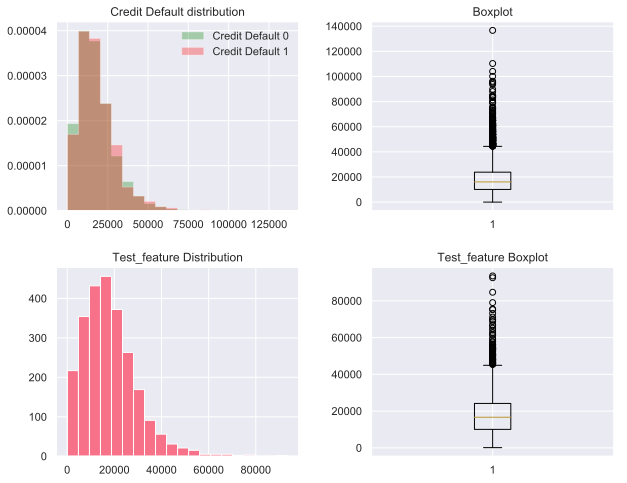

In [80]:
feat_plot('Monthly Debt')

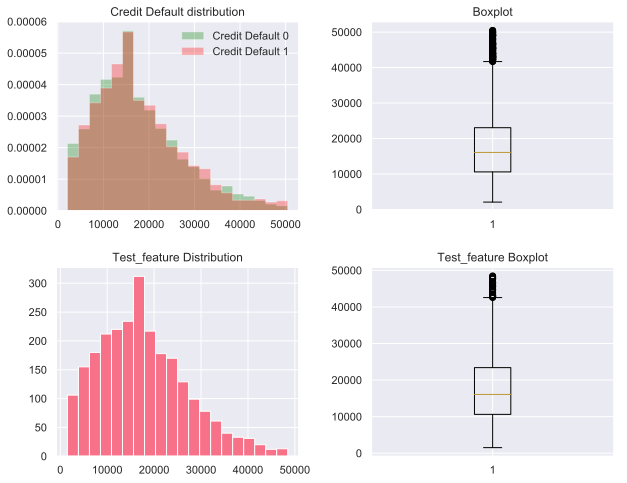

In [81]:
change_col('Monthly Debt')
change_col_test('Monthly Debt')
feat_plot('Monthly Debt')

**Кредитный скоринг**

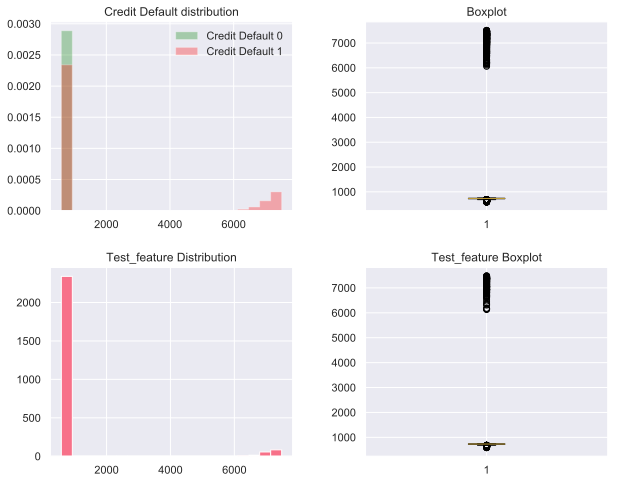

In [82]:
feat_plot('Credit Score')

Выбросы тут как-будто образуют отдельный класс. Сильная корреляция с целевой переменной говорит о том, что высокий балл характеризует ненадежных заемщиков. Возможно этот признак нужно перевести в категориальный.

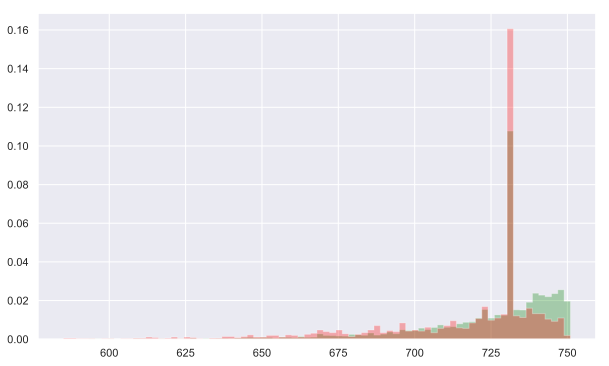

In [83]:
plt.figure(figsize=(10, 6))
default = train.loc[(train ['Credit Default'] == 1) & (train ['Credit Score'] < 2000), 'Credit Score']
not_default = train.loc[(train ['Credit Default'] == 0) & (train ['Credit Score'] < 2000), 'Credit Score']
plt.hist((default, not_default), bins=80, histtype='stepfilled', alpha=0.3, color=('red', 'green'),
             density=True, label=('Credit Default 1', 'Credit Default 0'));

In [84]:
train.loc[(train ['Credit Default'] == 1) & (train ['Credit Score'] < 2000), 'Credit Score'].value_counts().head()

731.0    546
737.0     29
738.0     28
739.0     26
729.0     25
Name: Credit Score, dtype: int64

In [85]:
train.loc[(train ['Credit Default'] == 0) & (train ['Credit Score'] < 2000), 'Credit Score'].value_counts().head()

731.0    1105
740.0     148
747.0     145
748.0     141
745.0     136
Name: Credit Score, dtype: int64

Создадим новый признак на основе 'Credit Score', с тремя категориями: 'a' для скоринга до 731 балла включительно, 'b' от 731 до 2000, 'c'- более 2000.

In [86]:
train['Score_cat'] = 'a'
train.loc[(train ['Credit Score'] > 731) & (train ['Credit Score'] < 2000), 'Score_cat'] = 'b'
train.loc[train ['Credit Score'] >= 2000, 'Score_cat'] = 'c'

Необходимо создать этот же признак в тестовом датасете.

In [87]:
test['Score_cat'] = 'a'
test.loc[(test ['Credit Score'] > 731) & (test ['Credit Score'] < 2000), 'Score_cat'] = 'b'
test.loc[test ['Credit Score'] >= 2000, 'Score_cat'] = 'c'

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null float64
Years in current job            7500 non-null object
Tax Liens                       7500 non-null int32
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null int32
Months since last delinquent    7500 non-null int32
Bankruptcies                    7500 non-null int32
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-nu

**Обзор номинативных признаков**

In [89]:
for cat_colname in train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [90]:
def countplot(feature):
    
    plt.figure(figsize=(12, 6))
    sns.countplot(y=feature, hue=target, data=train)
    plt.legend(title='Target', loc='lower right')

**Home Ownership - домовладение**

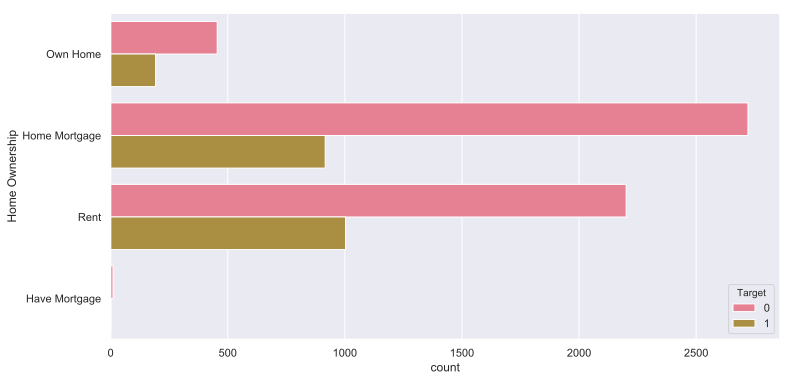

In [91]:
countplot("Home Ownership")

**Years in current job - количество лет на текущем месте работы**

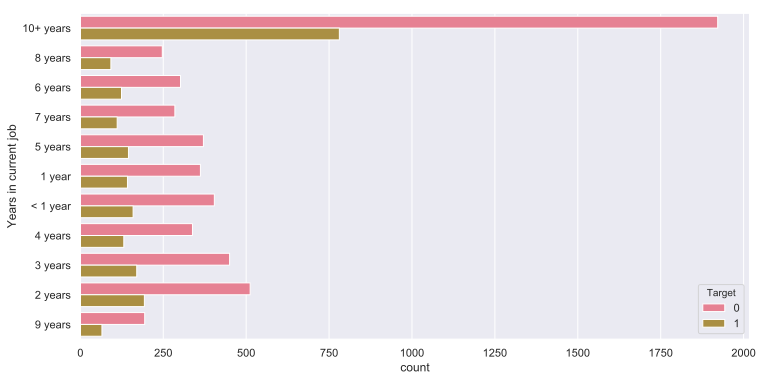

In [92]:
countplot("Years in current job")

In [93]:
train.loc[train['Years in current job'] == '< 1 year', 'Years in current job'] = 'lesser 1 year'
test.loc[test['Years in current job'] == '< 1 year', 'Years in current job'] = 'lesser 1 year'

**Purpose - цель кредита**

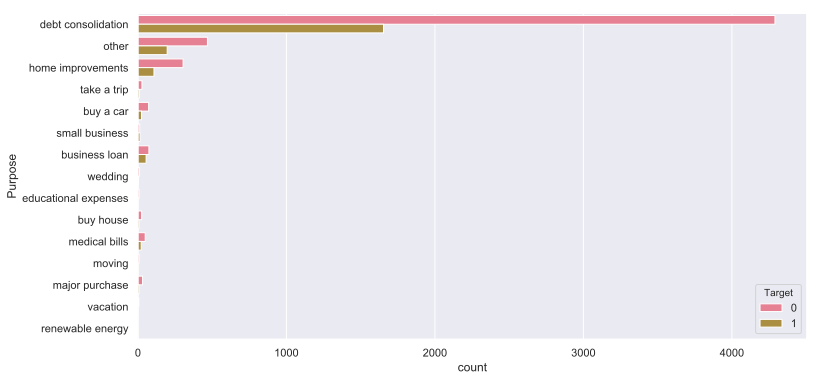

In [94]:
countplot("Purpose")

Уменьшим количество категорий. Объединим категории "business loan" и "small business", у них большая доля невыплаченных кредитов. Также объединим мелкие категории.

In [95]:
train.loc[train['Purpose'] == 'small business', 'Purpose'] = 'business loan'
train.loc[train['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

In [96]:
train['Purpose'].value_counts()

debt consolidation    5944
other                  665
home improvements      412
major purchase         324
business loan          155
Name: Purpose, dtype: int64

In [97]:
test.loc[test['Purpose'] == 'small business', 'Purpose'] = 'business loan'
test.loc[test['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

**Term - срок кредита**

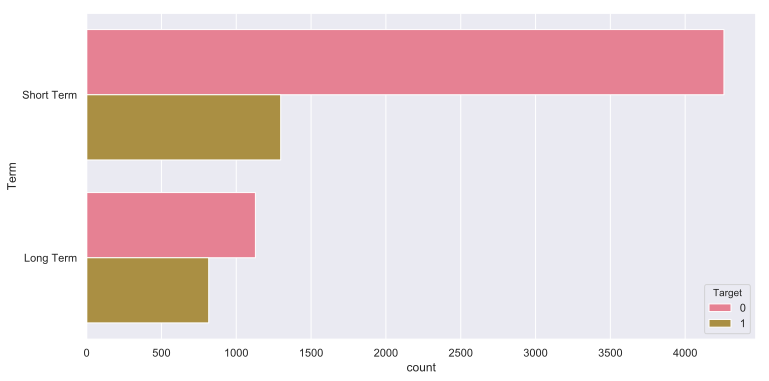

In [98]:
countplot("Term")

Преобразуем этот признак, пусть короткий период времени будет 0, а длинный - 1.

In [99]:
train.loc[train['Term'] == 'Long Term', 'Term'] = 1
train.loc[train['Term'] == 'Short Term', 'Term'] = 0
train['Term'] = train['Term'].astype('int')

In [100]:
test.loc[test['Term'] == 'Long Term', 'Term'] = 1
test.loc[test['Term'] == 'Short Term', 'Term'] = 0
test['Term'] = test['Term'].astype('int')

**Score_cat**

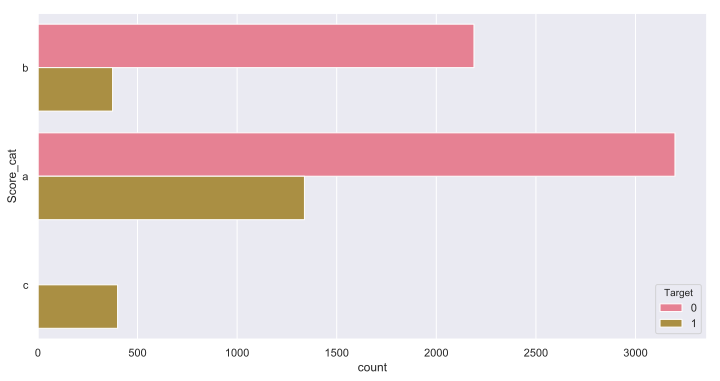

In [101]:
countplot("Score_cat")

### Построение новых признаков

### Сохранение датасета

Для CatBoost нам не нужны дамми. Сохраним датасет и списки признаков.

In [102]:
basic_features = train.columns.drop(target).drop('Id').tolist()
basic_features

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Score_cat']

In [103]:
numeric_features = train.select_dtypes(include='float').columns.tolist()
numeric_features

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [104]:
category_features = train.select_dtypes(include=('object')).columns.tolist()
category_features

['Home Ownership', 'Years in current job', 'Purpose', 'Score_cat']

In [105]:
binomial_features = train.select_dtypes(include=('int32')).columns.tolist()
binomial_features

['Tax Liens',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term']

In [106]:
selected_features = numeric_features + binomial_features + category_features
selected_features

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Tax Liens',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Home Ownership',
 'Years in current job',
 'Purpose',
 'Score_cat']

In [107]:
CAT_DATASET_PATH = 'course_project_cat.csv'
train.to_csv(CAT_DATASET_PATH, index=False, encoding='utf-8')

**Dummies**

In [108]:
train = pd.get_dummies(train)

In [109]:
test = pd.get_dummies(test)

### Отбор признаков

In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 38 columns):
Id                                    7500 non-null int64
Annual Income                         7500 non-null float64
Tax Liens                             7500 non-null int32
Number of Open Accounts               7500 non-null float64
Years of Credit History               7500 non-null float64
Maximum Open Credit                   7500 non-null float64
Number of Credit Problems             7500 non-null int32
Months since last delinquent          7500 non-null int32
Bankruptcies                          7500 non-null int32
Term                                  7500 non-null int32
Current Loan Amount                   7500 non-null float64
Current Credit Balance                7500 non-null float64
Monthly Debt                          7500 non-null float64
Credit Score                          7500 non-null float64
Credit Default                        7500 non-null int64
Home Ow

In [111]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
Id                                    2500 non-null int64
Annual Income                         2500 non-null float64
Tax Liens                             2500 non-null int32
Number of Open Accounts               2500 non-null float64
Years of Credit History               2500 non-null float64
Maximum Open Credit                   2500 non-null float64
Number of Credit Problems             2500 non-null int32
Months since last delinquent          2500 non-null int32
Bankruptcies                          2500 non-null int32
Term                                  2500 non-null int32
Current Loan Amount                   2500 non-null float64
Current Credit Balance                2500 non-null float64
Monthly Debt                          2500 non-null float64
Credit Score                          2500 non-null float64
Home Ownership_Have Mortgage          2500 non-null uint8
Home Ow

In [112]:
basic_feats = train.columns.drop(target).drop('Id').tolist()
basic_feats

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_lesser 1 year',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_other',
 'Score_cat_a',
 'Score_cat_b',
 'Score_cat_c']

In [113]:
numeric_feats = train.select_dtypes(include='float').columns.tolist()
numeric_feats

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [114]:
category_feats = train.select_dtypes(include=('uint8')).columns.tolist()
category_feats

['Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_lesser 1 year',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_other',
 'Score_cat_a',
 'Score_cat_b',
 'Score_cat_c']

In [115]:
binomial_feats = train.select_dtypes(include=('int32')).columns.tolist()
binomial_feats

['Tax Liens',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term']

In [116]:
selected_feats = numeric_features + binomial_features + category_feats
selected_feats

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Tax Liens',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_lesser 1 year',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_other',
 'Score_cat_a',
 'Score_cat_b',
 'Score_cat_c']

Посмотрим еще раз на корреляцию признаков с целевой переменной.

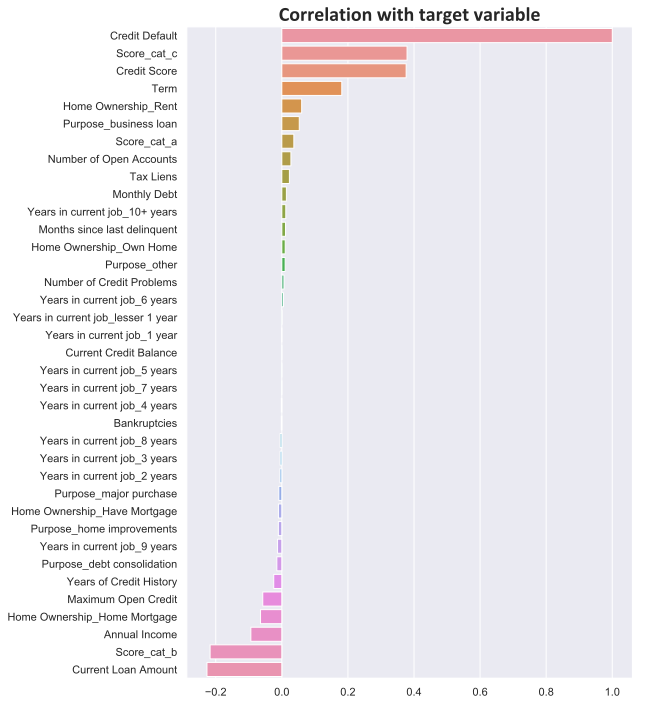

In [117]:
corr_with_target = train[selected_feats + [target]].corr().loc[target].sort_values(ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable', fontdict=title_dict);

### Нормализация данных

In [118]:
scaler = MinMaxScaler()

train_norm = train.copy()
train_norm[numeric_feats] = scaler.fit_transform(train_norm[numeric_feats])

In [119]:
test_norm = test.copy()
test_norm[numeric_feats] = scaler.fit_transform(test_norm[numeric_feats])

In [120]:
# For CatBoost
train_norm_cat = pd.read_csv(CAT_DATASET_PATH)
train_norm_cat[numeric_features] = scaler.fit_transform(train_norm_cat[numeric_features])

In [121]:
train_norm_cat.columns.tolist()

['Id',
 'Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Score_cat']

### Разбиение на train и test

In [122]:
X = train_norm[selected_feats]
y = train_norm[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

In [123]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5168 to 7270
Data columns (total 36 columns):
Annual Income                         5625 non-null float64
Number of Open Accounts               5625 non-null float64
Years of Credit History               5625 non-null float64
Maximum Open Credit                   5625 non-null float64
Current Loan Amount                   5625 non-null float64
Current Credit Balance                5625 non-null float64
Monthly Debt                          5625 non-null float64
Credit Score                          5625 non-null float64
Tax Liens                             5625 non-null int32
Number of Credit Problems             5625 non-null int32
Months since last delinquent          5625 non-null int32
Bankruptcies                          5625 non-null int32
Term                                  5625 non-null int32
Home Ownership_Have Mortgage          5625 non-null uint8
Home Ownership_Home Mortgage          5625 non-null uint8
Home

In [124]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 970 to 6891
Data columns (total 36 columns):
Annual Income                         1875 non-null float64
Number of Open Accounts               1875 non-null float64
Years of Credit History               1875 non-null float64
Maximum Open Credit                   1875 non-null float64
Current Loan Amount                   1875 non-null float64
Current Credit Balance                1875 non-null float64
Monthly Debt                          1875 non-null float64
Credit Score                          1875 non-null float64
Tax Liens                             1875 non-null int32
Number of Credit Problems             1875 non-null int32
Months since last delinquent          1875 non-null int32
Bankruptcies                          1875 non-null int32
Term                                  1875 non-null int32
Home Ownership_Have Mortgage          1875 non-null uint8
Home Ownership_Home Mortgage          1875 non-null uint8
Home 

Разбиение для CatBoost

In [125]:
X_cat = train_norm_cat[selected_features]
y_cat = train_norm_cat[target]

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, shuffle=True, 
                                                                    test_size=0.25, random_state=42)

### Балансировка целевой переменной

In [126]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

0    4074
1    3102
Name: Credit Default, dtype: int64

In [127]:
X_train = df_balanced.drop(columns=target)
y_train = df_balanced[target]

In [128]:
df_for_balancing = pd.concat([X_cat_train, y_cat_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

0    4074
1    3102
Name: Credit Default, dtype: int64

In [129]:
X_cat_train = df_balanced.drop(columns=target)
y_cat_train = df_balanced[target]

### Построение и оценка базовых моделей

## Логистическая регрессия

In [130]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

report_regres = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
report_regres

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      4074
           1       0.71      0.53      0.60      3102

   micro avg       0.70      0.70      0.70      7176
   macro avg       0.70      0.68      0.68      7176
weighted avg       0.70      0.70      0.69      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.56      0.52      0.54       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1079  234
1                270  292


## Support Vector Machine

In [131]:
model_svc = SVC()
model_svc.fit(X_train, y_train)

y_train_pred = model_svc.predict(X_train)
y_test_pred = model_svc.predict(X_test)

report_svc = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
report_svc

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.82      0.75      4074
           1       0.68      0.50      0.58      3102

   micro avg       0.68      0.68      0.68      7176
   macro avg       0.68      0.66      0.66      7176
weighted avg       0.68      0.68      0.67      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1313
           1       0.54      0.52      0.53       562

   micro avg       0.72      0.72      0.72      1875
   macro avg       0.67      0.66      0.67      1875
weighted avg       0.72      0.72      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1065  248
1                271  291


**Бустинговые алгоритмы**

## XGBoost

In [132]:
model_xgb = xgb.XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

report_xgb = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
report_xgb

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      4074
           1       0.77      0.56      0.65      3102

   micro avg       0.74      0.74      0.74      7176
   macro avg       0.75      0.72      0.72      7176
weighted avg       0.74      0.74      0.73      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1313
           1       0.57      0.48      0.52       562

   micro avg       0.74      0.74      0.74      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1115  198
1                295  267


## LightGBM

In [133]:
model_lgbm = lgbm.LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

report_lgbm = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
report_lgbm

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      4074
           1       0.95      0.87      0.91      3102

   micro avg       0.92      0.92      0.92      7176
   macro avg       0.93      0.92      0.92      7176
weighted avg       0.92      0.92      0.92      7176

TEST

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1313
           1       0.56      0.45      0.50       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.67      0.65      0.66      1875
weighted avg       0.72      0.73      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1117  196
1                310  252


## CatBoost

In [134]:
model_catb = catb.CatBoostClassifier(cat_features=category_features, silent=True)
model_catb.fit(X_cat_train, y_cat_train)

y_train_pred = model_catb.predict(X_cat_train)
y_test_pred = model_catb.predict(X_cat_test)

report_cat = get_classification_report(y_cat_train, y_train_pred, y_cat_test, y_test_pred)
report_cat

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      4074
           1       0.84      0.67      0.75      3102

   micro avg       0.80      0.80      0.80      7176
   macro avg       0.81      0.79      0.79      7176
weighted avg       0.81      0.80      0.80      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1313
           1       0.56      0.48      0.52       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1099  214
1                290  272


### Выбор наилучшей модели, настройка гиперпараметров

**Подбор гиперпараметров**

## Support Vector Machine

In [135]:
# c_values = np.linspace(0.1, 10, 36)

# accuracy_on_test = []
# accuracy_on_train = []

# for i, value in enumerate(c_values):
#     model_svc = SVC(C=value, gamma="auto")
    
#     model_svc.fit(X_train, y_train)
    
#     y_pred = model_svc.predict(X_test)
#     y_pred_train = model_svc.predict(X_train)
        
#     acc_test = f1_score(y_test, y_pred)
#     acc_train = f1_score(y_train, y_pred_train)
    
    
#     print('C = {}'.format(value))
#     print('\tacc_test = {}'.format(acc_test))
#     print('\tacc_train = {}\n'.format(acc_train))
    
#     accuracy_on_test.append(acc_test)
#     accuracy_on_train.append(acc_train)

In [136]:
# plt.plot(c_values, accuracy_on_test, label="test")
# plt.plot(c_values, accuracy_on_train, label="train")

# plt.xlabel('Значение параметра C')
# plt.ylabel('f1_score')

# plt.legend()
# plt.grid();

## XGBoost

In [137]:
# %%time

# def auc(m, train, test): 
#     return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
#                             metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

# # Parameter Tuning
# model = xgb.XGBClassifier()

# param_dist = {"max_depth": [7, 10, 30, 50],
#               "min_child_weight" : [1, 3, 6],
#               "n_estimators": [50, 100, 200],
#               "learning_rate": [0.05, 0.1, 0.16],}

# grid_search = GridSearchCV(model, param_grid=param_dist, cv=3, 
#                                    scoring='f1', verbose=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_

# print(f'grid_search.best_params: {best_params}')
# print(f'grid_search.best_score: {grid_search.best_score_}')

## LightGBM

In [138]:
# %%time

# params = {'num_leaves':[160, 170, 120, 150, 180],
#           'max_depth': [28, 32, 31, 30, 25, 29],
#           'learning_rate':[0.15, 0.05, 0.1, 0.20, 0.25],
#           'max_bin': [145, 140, 200, 150, 500, 160],
# 'min_split_gain': [0.04, 0.06, 0.5, 10, 0.05, 0.055], 
# 'reg_alpha': [3.0, 2.4, 2.3, 2.0, 4.0, 2.5, 2.6], 
# 'reg_lambda': [10.0, 16.0, 3.0, 14.0, 4.0, 17.0, 15.0, 200.0]}

# crv=KFold(n_splits=3, random_state=100, shuffle=True)

# rs_lgbm = RandomizedSearchCV(model_lgbm, params, scoring='recall', cv=crv, n_jobs=-1)
# rs_lgbm.fit(X_train, y_train)

# best_params = rs_lgbm.best_params_

# print(f'lgbm.best_params: {best_params}')
# print(f'lgbm.best_score: {rs_lgbm.best_score_}')

## CatBoost

In [139]:
cv_dataset = Pool(data=X_cat_train,
                  label=y_cat_train,
                  cat_features=category_features)

params = {"iterations": 300,
          "depth": 10,
          "loss_function": "Logloss",
          "l2_leaf_reg": 300,
          "verbose": False}

scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [140]:
# %%time

# colnames = X_cat_train.columns.tolist()
# train_set = X_cat_train
# test_set = X_cat_test

# category_cols = category_features
# cat_dims = [train_set.columns.get_loc(i) for i in category_cols[:-1]] 
# for header in category_cols:
#     train_set[header] = train_set[header].astype('category').cat.codes
#     test_set[header] = test_set[header].astype('category').cat.codes

# train_label = y_cat_train
# train_set = X_cat_train
# test_label = y_cat_test
# test_set = X_cat_test

# params = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,50,90],
#           'learning_rate':[0.03,0.001,0.01,0.15,0.2,0.3], 
#           'l2_leaf_reg':[300,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],
#           'thread_count':[6,4,3,5]}


# def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
#     kf = KFold(n_splits=n_splits,shuffle=True) 
#     res = []
#     for train_index, test_index in kf.split(train_set):
#         train = train_set.iloc[train_index,:]
#         test = train_set.iloc[test_index,:]

#         labels = train_label.ix[train_index]
#         test_labels = train_label.ix[test_index]

#         clf = catb.CatBoostClassifier(**params)
#         clf.fit(train, np.ravel(labels), cat_features=cat_dims)

#         res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
#     return np.mean(res)

# def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
#     ps = paramsearch(params)
#     for prms in chain(ps.grid_search(['border_count']),
#                       ps.grid_search(['l2_leaf_reg']),
#                       ps.grid_search(['iterations','learning_rate']),
#                       ps.grid_search(['depth'])):
#         res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
#         ps.register_result(res,prms)
#         print(res,prms,ps.bestscore(),ps.bestparam())
#     return ps.bestparam()

# bestparams = catboost_param_tune(params,X_cat_train,y_cat_train,cat_dims)
# bestparams

In [141]:
# clf = catb.CatBoostClassifier(**bestparams)
# clf.fit(train_set, np.ravel(train_label), cat_features=cat_dims)

# y_train_pred = clf.predict(train_set)
# y_test_pred = clf.predict(test_set)
# cat_report = get_classification_report(y_cat_train, y_train_pred, y_cat_test, y_test_pred)
# cat_report

**Обучение и оценка финальной модели**

## SVC

In [142]:
final_model_svc = SVC()
model_svc.fit(X_train, y_train)

y_train_pred = model_svc.predict(X_train)
y_test_pred = model_svc.predict(X_test)

report_svc = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
report_svc

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.82      0.75      4074
           1       0.68      0.50      0.58      3102

   micro avg       0.68      0.68      0.68      7176
   macro avg       0.68      0.66      0.66      7176
weighted avg       0.68      0.68      0.67      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1313
           1       0.54      0.52      0.53       562

   micro avg       0.72      0.72      0.72      1875
   macro avg       0.67      0.66      0.67      1875
weighted avg       0.72      0.72      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1065  248
1                271  291


## XGBClassifier

In [143]:
%%time

final_model_xgb = xgb.XGBClassifier(lambda_l2=20,
                                       n_estimators=100,
                                       max_depth=7,
                                       learning_rate=0.1,
                                       random_state=42)
final_model_xgb.fit(X_train, y_train)

y_train_pred = final_model_xgb.predict(X_train)
y_test_pred = final_model_xgb.predict(X_test)

xgb_ = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
xgb_

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4074
           1       0.91      0.80      0.85      3102

   micro avg       0.88      0.88      0.88      7176
   macro avg       0.89      0.87      0.88      7176
weighted avg       0.88      0.88      0.88      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1313
           1       0.58      0.46      0.52       562

   micro avg       0.74      0.74      0.74      1875
   macro avg       0.69      0.66      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1127  186
1                302  260
Wall time: 2.81 s


## LGBMClassifier

In [144]:
%%time

final_model_lgbm = lgbm.LGBMClassifier(reg_lambda=350.0,num_leaves=70,reg_alpha=2.5,
                                       min_split_gain=0.05,
                                       max_depth=7,
                                       max_bin=150,
                                       learning_rate=0.15,
                                       random_state=42,
                                       )
final_model_lgbm.fit(X_train, y_train)

y_train_pred = final_model_lgbm.predict(X_train)
y_test_pred = final_model_lgbm.predict(X_test)
y_test_pred_probs = final_model_lgbm.predict_proba(X_test)

lgbm_ = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
lgbm_

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      4074
           1       0.77      0.59      0.67      3102

   micro avg       0.75      0.75      0.75      7176
   macro avg       0.75      0.73      0.73      7176
weighted avg       0.75      0.75      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1313
           1       0.57      0.51      0.54       562

   micro avg       0.74      0.74      0.74      1875
   macro avg       0.69      0.67      0.68      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1100  213
1                277  285
Wall time: 250 ms


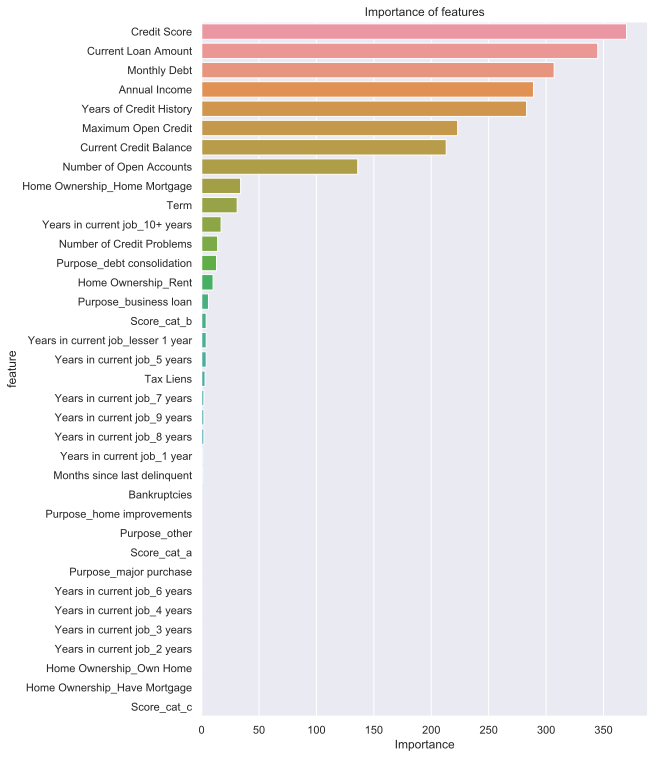

In [145]:
important_features_top = show_feature_importances(X_train.columns, final_model_lgbm.feature_importances_, get_top=20)

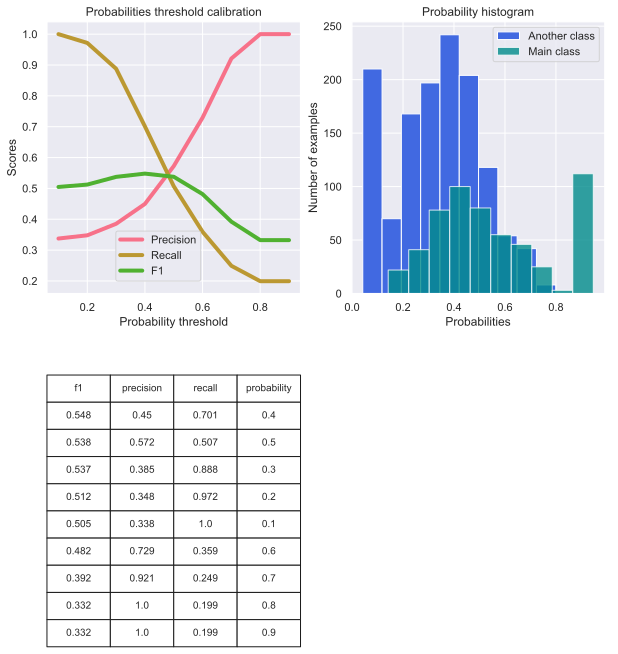

In [146]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

## CatBoostClassifier

In [147]:
%%time

final_model_cat = catb.CatBoostClassifier(cat_features=category_features,
                            iterations=100,
                           depth=5,
                           l2_leaf_reg=100,
                            silent=True,
                           random_state=42)
final_model_cat.fit(X_cat_train, y_cat_train)

y_train_pred = final_model_cat.predict(X_cat_train)
y_test_pred = final_model_cat.predict(X_cat_test)

cat = get_classification_report(y_cat_train, y_train_pred, y_cat_test, y_test_pred)
cat

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4074
           1       0.77      0.42      0.54      3102

   micro avg       0.70      0.70      0.70      7176
   macro avg       0.72      0.66      0.66      7176
weighted avg       0.72      0.70      0.67      7176

TEST

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1313
           1       0.63      0.42      0.50       562

   micro avg       0.75      0.75      0.75      1875
   macro avg       0.71      0.66      0.67      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1177  136
1                328  234
Wall time: 1.73 s


### Важность признаков

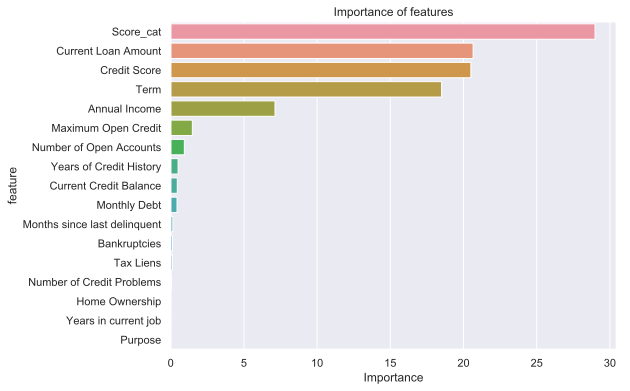

In [148]:
important_features_top = show_feature_importances(X_cat_train.columns, final_model_cat.feature_importances_, get_top=20)

In [149]:
important_features_top

['Score_cat',
 'Current Loan Amount',
 'Credit Score',
 'Term',
 'Annual Income',
 'Maximum Open Credit',
 'Number of Open Accounts',
 'Years of Credit History',
 'Current Credit Balance',
 'Monthly Debt',
 'Months since last delinquent',
 'Bankruptcies',
 'Tax Liens',
 'Number of Credit Problems',
 'Home Ownership',
 'Years in current job',
 'Purpose']

### Финальная модель

In [150]:
final_model_lgbm = lgbm.LGBMClassifier(reg_lambda=350.0,num_leaves=70,reg_alpha=2.5,
                                       min_split_gain=0.05,
                                       max_depth=7,
                                       max_bin=150,
                                       learning_rate=0.15,
                                       random_state=42,
                                       )
final_model_lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.15, max_bin=150,
        max_depth=7, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.05, n_estimators=100, n_jobs=-1, num_leaves=70,
        objective=None, random_state=42, reg_alpha=2.5, reg_lambda=350.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

## Прогнозирование на тестовом датасете

In [151]:
# # Prediction on Test
# test_norm['Credit Default'] = final_model_lgbm.predict(test_norm[selected_feats])

# PRED_PATH = 'ATaganova_predictions.csv'

# test_norm.loc[:, ['Id', 'Credit Default']].to_csv(PRED_PATH, index=False, encoding='utf-8')